In [248]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [113]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

In [14]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [256]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [15]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [17]:
encod = Pipeline([
                ('selector', FeatureSelector(column=['Gender', 'Geography'])),
                ('ohe', OHEEncoder(key=['Gender', 'Geography']))
            ])
encod.fit(X_train)
encod.transform(X_test).head(3)

,Gender_Female,Gender_Male,Geography_France,Geography_Germany,Geography_Spain
9394,1,0,0,1,0
898,1,0,1,0,0
2398,1,0,0,0,1


Теперь нам нужно под каждый признак создать трансформер и объединить их в список.

In [19]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн.

In [20]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Логистическая регрессия.

In [250]:
logit_pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(max_iter=200, tol=1e-5, random_state = 43)),
])

In [251]:
logit_pipeline.fit(X_train, y_train)
logit_preds = logit_pipeline.predict_proba(X_test)[:, 1]
logit_preds[:10]

array([0.22805865, 0.3350657 , 0.15347886, 0.12466446, 0.15507743,
       0.6431308 , 0.06214346, 0.077948  , 0.36717132, 0.76751542])

In [252]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, logit_preds)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568


Градиентный бустинг sklearn.

In [27]:
from hyperopt import fmin, tpe, hp, Trials

In [31]:
from functools import partial
from hyperopt.pyll.base import scope

In [230]:
def optimize(params, x, y):
    boost_pipeline = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(**params))
    ])
    kf = StratifiedKFold(n_splits=5)
    cv_scores = cross_val_score(boost_pipeline, x, y, cv=kf, scoring='roc_auc')
    return np.mean(cv_scores)

In [231]:
param_space = {
    "max_depth": scope.int(hp.quniform("max_depth", 3, 7, 1)),
    "n_estimators": scope.int(hp.quniform("n_estimators", 100, 600, 10)),
    "learning_rate": hp.quniform("learning_rate", 0.05, 1, 0.01),
    "criterion": hp.choice("criterion", ['friedman_mse', 'mse'])
    }

In [232]:
optimization_function = partial(optimize,
                                 x=X_train, 
                                 y=y_train)

In [233]:
trials = Trials()

In [234]:
%%time
result = fmin(fn=optimization_function, space=param_space, algo=tpe.suggest, max_evals=5, trials=trials)

print(result)

100%|██████████████████████████████████████████████████| 5/5 [01:54<00:00, 22.95s/trial, best loss: 0.8138938984234553]
{'criterion': 1, 'learning_rate': 0.96, 'max_depth': 5.0, 'n_estimators': 340.0}
Wall time: 1min 54s


In [253]:
#обучим пайплайн на всем тренировочном датасете
boost_pipeline = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(criterion='mse',
                                             learning_rate=0.96,
                                             max_depth=5,
                                             n_estimators=340))
    ])
boost_pipeline.fit(X_train, y_train)
gb_preds = boost_pipeline.predict_proba(X_test)[:, 1]
gb_preds[:10]

array([2.17986287e-01, 3.36263403e-03, 3.72020749e-04, 2.18410995e-04,
       1.00907857e-05, 9.97817247e-01, 1.76920689e-06, 7.92442171e-03,
       1.32886709e-03, 9.98026795e-01])

In [254]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, preds)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.305050, F-Score=0.589, Precision=0.608, Recall=0.572


Результаты всех метрик значительно лучше. Посмотрим на Roc-Auc.

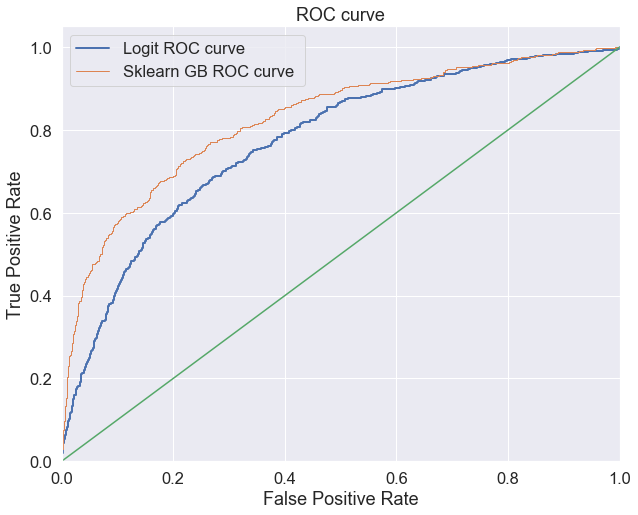

In [255]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, logit_preds, pos_label=1)
fpr1, tpr1, thresholds_ = roc_curve(y_test, gb_preds, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='Logit ROC curve ')
plt.plot(fpr1, tpr1, lw=1, label='Sklearn GB ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

В задаче оттока необходимо определять каких клиентов отнести к оттоку, т.е. нас всего интетересует один класс - максимум TP
при минимуме FP. Поэтому оценивать лучше по precision-recall кривой, а кривую ROC-AUC можно использовать как дополнительную интегральную оценку того, что наш классификатор не совсем случаен.

Проведём экономическую оценку градиентного бустинга.

Confusion matrix, without normalization
[[1801  190]
 [ 218  291]]


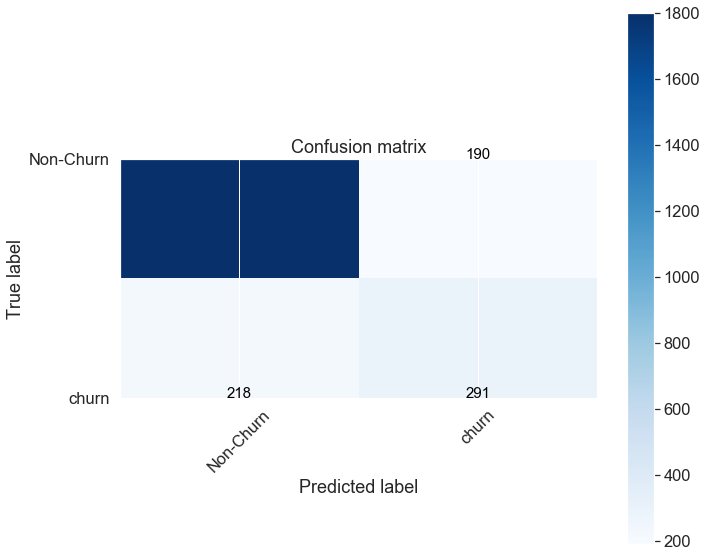

In [257]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, gb_preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [263]:
print(f'Выручка с каждого правильно классицированного равна {cnf_matrix[0][0]*2} доллара')

Выручка с каждого правильно классицированного равна 3602 доллара


In [265]:
print(f'Затраты на привлечение составили {y_test.shape[0]} долларов')

Затраты на привлечение составили 2500 долларов


In [267]:
print(f'Экономический эффект составил {(cnf_matrix[0][0]*2) - y_test.shape[0]} долларов')

Экономический эффект составил 1102 долларов
